In [1]:
from __future__ import annotations

import os
import datetime
import re
import sys
sys.path.append("../utils")
import _confusion_matrix
import _gridsearch

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

def all_classifiers() -> list[tuple[str, type]]:
    """Return a dictionary of all classifiers in sklearn."""
    return [(name, estimator) for name, estimator in all_estimators()
            if issubclass(estimator, ClassifierMixin)]

def _cmp(a: int, b: int) -> int:
    """Forward-porting Python 2 `cmp` function."""
    return (a > b) - (a < b) # negative if a < b, 0 if a == b, positive if a > b

_cmp(len(all_classifiers()), len(all_estimators()))

-1

In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [4]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw_pos{}.csv"
RAW_DATA_MAXLEN = ['none', '300', '200']

In [5]:
models_df = pd.DataFrame({
    'model': ['LSVM', 'SGDClassifier'],
    'base': [LinearSVC(max_iter=5000), SGDClassifier(max_iter=5000)],
    'params': [
        {
            'ct__vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'ct__pos__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'clf__C': np.logspace(-3, 3, 7),
            'clf__penalty': ['l1', 'l2'],
            'clf__loss': ['hinge', 'squared_hinge'],
        },
        {
            'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
            'clf__penalty': ['l1', 'l2'],
            'clf__loss': ['hinge', 'squared_hinge', 'log_loss'], # 'log' is deprecated in 1.1
        },
    ],
})

with pd.option_context('display.max_colwidth', None):
    ipy_display(models_df)

,model,base,params
0,LinearSVC,LinearSVC(max_iter=5000),"{'ct__vect__ngram_range': [(1, 1), (1, 2), (1, 3)], 'ct__pos__ngram_range': [(1, 1), (1, 2), (1, 3)], 'clf__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf__penalty': ['l1', 'l2'], 'clf__loss': ['hinge', 'squared_hinge']}"
1,SGDClassifier,SGDClassifier(max_iter=5000),"{'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'clf__penalty': ['l1', 'l2'], 'clf__loss': ['hinge', 'squared_hinge', 'log_loss']}"


Maxlen: none
<generator object <genexpr> at 0x00000240217D4740>

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1260 fits failed out of a total of 2520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
630 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\svm\_classes.py", line 257,

Best params: {'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'ct__pos__ngram_range': (1, 1), 'ct__vect__ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1041
           1       0.73      0.78      0.75       988

    accuracy                           0.75      2029
   macro avg       0.75      0.75      0.75      2029
weighted avg       0.75      0.75      0.75      2029


Saved confusion matrix: ../results/figures/linearsv_0.75_none_20221223_1612.svg


,params,mean_test_score,rank_test_score
119,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.779581,1
137,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.779116,2
136,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.778474,3
118,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.777862,4
209,"{'clf__C': 100.0, 'clf__loss': 'squared_hinge'...",0.777065,5
...,...,...,...
37,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,248
36,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,249
144,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,250
146,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,251


,params,mean_test_score,rank_test_score
119,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.779581,1
137,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.779116,2
136,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.778474,3
118,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.777862,4
209,"{'clf__C': 100.0, 'clf__loss': 'squared_hinge'...",0.777065,5
...,...,...,...
37,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,248
36,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,249
144,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,250
146,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,251


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.80      0.66      0.73      1041
           1       0.70      0.83      0.76       988

    accuracy                           0.74      2029
   macro avg       0.75      0.75      0.74      2029
weighted avg       0.75      0.74      0.74      2029


Saved confusion matrix: ../results/figures/sgd_0.743_none_20221223_1614.svg


,params,mean_test_score,rank_test_score
1,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.770359,1
5,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.768499,2
4,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.766449,3
0,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.763886,4
7,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.748346,5
3,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.745612,6
11,"{'clf__alpha': 0.001, 'clf__loss': 'log_loss',...",0.739582,7
2,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.736501,8
8,"{'clf__alpha': 0.001, 'clf__loss': 'squared_hi...",0.720536,9
6,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.698279,10


,params,mean_test_score,rank_test_score
1,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.770359,1
5,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.768499,2
4,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.766449,3
0,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.763886,4
7,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.748346,5
3,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.745612,6
11,"{'clf__alpha': 0.001, 'clf__loss': 'log_loss',...",0.739582,7
2,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.736501,8
8,"{'clf__alpha': 0.001, 'clf__loss': 'squared_hi...",0.720536,9
6,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.698279,10


Maxlen: 300
<generator object <genexpr> at 0x00000240217D47B0>

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1260 fits failed out of a total of 2520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
630 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\svm\_classes.py", line 257,

Best params: {'clf__C': 1.0, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'ct__pos__ngram_range': (1, 1), 'ct__vect__ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       558
           1       0.86      0.76      0.81       710

    accuracy                           0.80      1268
   macro avg       0.80      0.80      0.80      1268
weighted avg       0.80      0.80      0.80      1268


Saved confusion matrix: ../results/figures/linearsv_0.796_300_20221223_1707.svg


,params,mean_test_score,rank_test_score
137,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.773755,1
119,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.772417,2
139,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.772210,3
176,"{'clf__C': 10.0, 'clf__loss': 'squared_hinge',...",0.772123,4
122,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.771767,5
...,...,...,...
144,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,248
145,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,249
146,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,250
133,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",NaN,251


,params,mean_test_score,rank_test_score
137,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.773755,1
119,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.772417,2
139,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.772210,3
176,"{'clf__C': 10.0, 'clf__loss': 'squared_hinge',...",0.772123,4
122,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.771767,5
...,...,...,...
144,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,248
145,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,249
146,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,250
133,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",NaN,251


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       558
           1       0.83      0.82      0.82       710

    accuracy                           0.81      1268
   macro avg       0.80      0.80      0.80      1268
weighted avg       0.81      0.81      0.81      1268


Saved confusion matrix: ../results/figures/sgd_0.804_300_20221223_1709.svg


,params,mean_test_score,rank_test_score
5,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.767619,1
4,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.760809,2
1,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.758394,3
0,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.756583,4
7,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.742955,5
3,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.738465,6
11,"{'clf__alpha': 0.001, 'clf__loss': 'log_loss',...",0.733420,7
2,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.729217,8
8,"{'clf__alpha': 0.001, 'clf__loss': 'squared_hi...",0.709656,9
6,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.705518,10


,params,mean_test_score,rank_test_score
5,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.767619,1
4,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.760809,2
1,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.758394,3
0,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.756583,4
7,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.742955,5
3,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.738465,6
11,"{'clf__alpha': 0.001, 'clf__loss': 'log_loss',...",0.733420,7
2,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.729217,8
8,"{'clf__alpha': 0.001, 'clf__loss': 'squared_hi...",0.709656,9
6,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.705518,10


Maxlen: 200
<generator object <genexpr> at 0x0000024029C76970>

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1260 fits failed out of a total of 2520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
630 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\dimboump\workspace\GreekNLI\venv\lib\site-packages\sklearn\svm\_classes.py", line 257,

Best params: {'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'ct__pos__ngram_range': (1, 1), 'ct__vect__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       567
           1       0.81      0.82      0.81       744

    accuracy                           0.78      1311
   macro avg       0.78      0.78      0.78      1311
weighted avg       0.78      0.78      0.78      1311


Saved confusion matrix: ../results/figures/linearsv_0.781_200_20221223_1806.svg


,params,mean_test_score,rank_test_score
118,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.779965,1
136,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.779491,2
121,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.777297,3
139,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.777295,4
137,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.777272,5
...,...,...,...
37,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,248
36,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,249
144,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,250
146,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,251


,params,mean_test_score,rank_test_score
118,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.779965,1
136,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.779491,2
121,"{'clf__C': 1.0, 'clf__loss': 'hinge', 'clf__pe...",0.777297,3
139,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.777295,4
137,"{'clf__C': 1.0, 'clf__loss': 'squared_hinge', ...",0.777272,5
...,...,...,...
37,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,248
36,"{'clf__C': 0.01, 'clf__loss': 'hinge', 'clf__p...",NaN,249
144,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,250
146,"{'clf__C': 10.0, 'clf__loss': 'hinge', 'clf__p...",NaN,251


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       567
           1       0.79      0.83      0.81       744

    accuracy                           0.78      1311
   macro avg       0.77      0.77      0.77      1311
weighted avg       0.77      0.78      0.77      1311


Saved confusion matrix: ../results/figures/sgd_0.77_200_20221223_1809.svg


,params,mean_test_score,rank_test_score
5,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.770752,1
4,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.767675,2
1,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.764166,3
0,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.763107,4
7,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.751214,5
11,"{'clf__alpha': 0.001, 'clf__loss': 'log_loss',...",0.736266,6
3,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.732569,7
2,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.728440,8
8,"{'clf__alpha': 0.001, 'clf__loss': 'squared_hi...",0.712890,9
6,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.710559,10


,params,mean_test_score,rank_test_score
5,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.770752,1
4,"{'clf__alpha': 0.0001, 'clf__loss': 'log_loss'...",0.767675,2
1,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.764166,3
0,"{'clf__alpha': 0.0001, 'clf__loss': 'hinge', '...",0.763107,4
7,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.751214,5
11,"{'clf__alpha': 0.001, 'clf__loss': 'log_loss',...",0.736266,6
3,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.732569,7
2,"{'clf__alpha': 0.0001, 'clf__loss': 'squared_h...",0.728440,8
8,"{'clf__alpha': 0.001, 'clf__loss': 'squared_hi...",0.712890,9
6,"{'clf__alpha': 0.001, 'clf__loss': 'hinge', 'c...",0.710559,10


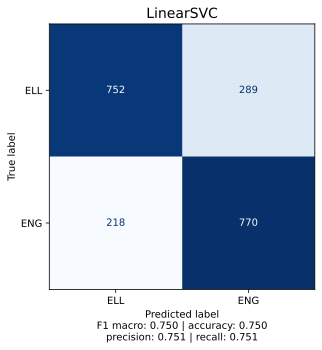

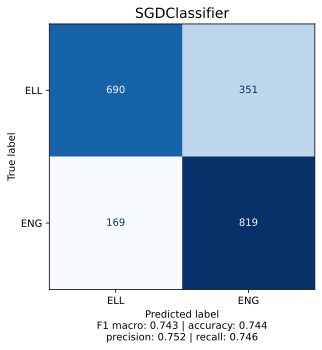

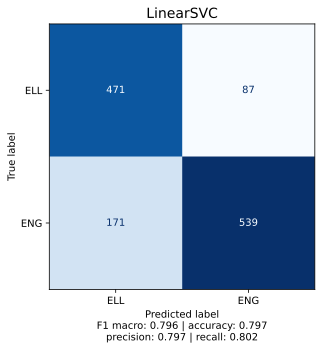

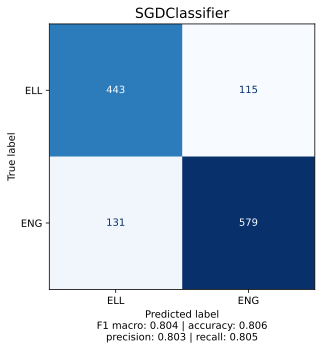

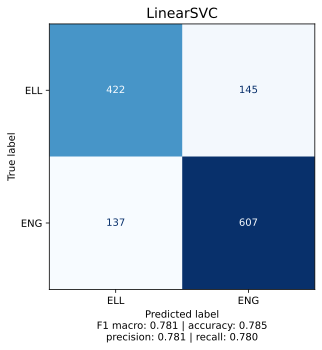

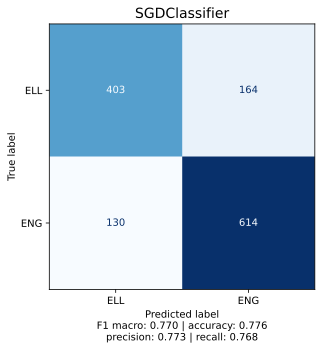

In [6]:
for maxlen in RAW_DATA_MAXLEN:
    print(f"Maxlen: {maxlen}")
    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''), 
                    encoding='utf-8')

    df, labels = encode_labels(df, 'label')

    X = df[['text', 'pos_tags']]
    y = df['label']

    gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print((split.shape for split in (X_train, X_test, y_train, y_test)), end="\n\n")

    vect = TfidfVectorizer()

    for model, params in zip(models_df['base'], models_df['params']):
        pipe = Pipeline([
            ('ct', ColumnTransformer(
                    [
                        ('vect', vect, 'text'),
                        ('pos', vect, 'pos_tags'),
                    ],
                )
            ),
            ('clf', model),
        ])

        gs = GridSearchCV(pipe, params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)
        gs.fit(X_train, y_train)
        print("Best params:", gs.best_params_, end="\n\n")
        y_pred = gs.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred), end="\n\n")

        cm = confusion_matrix(y_test, y_pred)
        _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment=maxlen)

        results_df = pd.DataFrame(gs.cv_results_)
        ipy_display(results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))
         
        all_results = pd.concat([results_df, pd.DataFrame(gs.cv_results_['params'])], axis=1)
        ipy_display(all_results[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

        try:
            models_df.loc[models_df['base'] == model, 'best_params'] = gs.best_params_
            models_df.loc[models_df['base'] == model, 'best_score'] = gs.best_score_
            models_df.loc[models_df['base'] == model, 'best_estimator'] = gs.best_estimator_
        except ValueError:
            models_df.loc[models_df['base'] == model, 'best_params'] = np.nan
            models_df.loc[models_df['base'] == model, 'best_score'] = np.nan
            models_df.loc[models_df['base'] == model, 'best_estimator'] = np.nan

In [7]:
ipy_display(models_df)

,model,base,params,best_params,best_score,best_estimator
0,LinearSVC,LinearSVC(max_iter=5000),"{'ct__vect__ngram_range': [(1, 1), (1, 2), (1,...",NaN,NaN,NaN
1,SGDClassifier,SGDClassifier(max_iter=5000),"{'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1], ...",NaN,NaN,NaN
